In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from models import *
from config import *

Using TensorFlow backend.


### Loading ground truth and generating mask from prediction

In [7]:
model = base_model(verbose=False)
model.load_weights(EXAMPLE_MODEL)

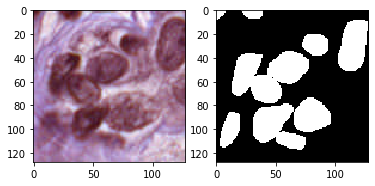

In [74]:
name = 'TCGA-A7-A13F-01Z-00-DX1_400_0_flip_rot_180.png'
# names = [f for f in os.listdir(TEST_IMG_PATH) if f.count('_') < 3]

img = cv2.imread(TEST_IMG_PATH + name)
ground_truth = cv2.imread(TEST_MASK_PATH + name, cv2.IMREAD_GRAYSCALE) 

fig=plt.figure(figsize=(6, 3))

fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(ground_truth, cmap='gray')

1/1 [==============================] - 0s 34ms/step


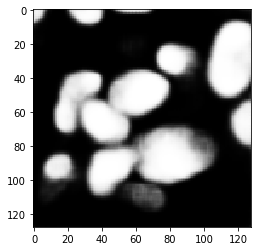

In [75]:
to_pred = np.zeros((1,*img.shape))
to_pred[0] = img
predicted = model.predict(to_pred, verbose=1)
predicted = np.squeeze(predicted)

plt.imshow(predicted, cmap='gray')

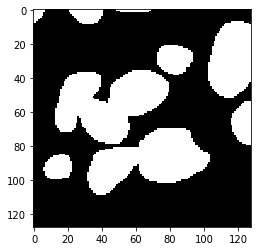

In [76]:
mask = predicted * 255
mask = mask.astype(dtype='uint8')
_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU)
plt.imshow(mask, cmap='gray')

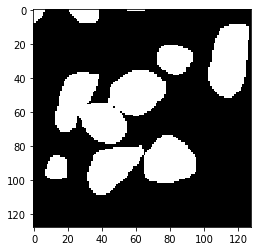

In [91]:
_ground_truth = ground_truth/255
_mask = mask/255
_intersection = _ground_truth * _mask
plt.imshow(_intersection, cmap='gray')

### Ground truth cells

Number of cells in the ground truth: 9


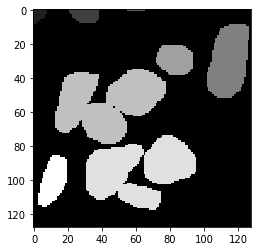

In [78]:
no_cells, cells = cv2.connectedComponents(ground_truth)
plt.imshow(cells*20, cmap='gray')
print("Number of cells in the ground truth: " + str(no_cells))

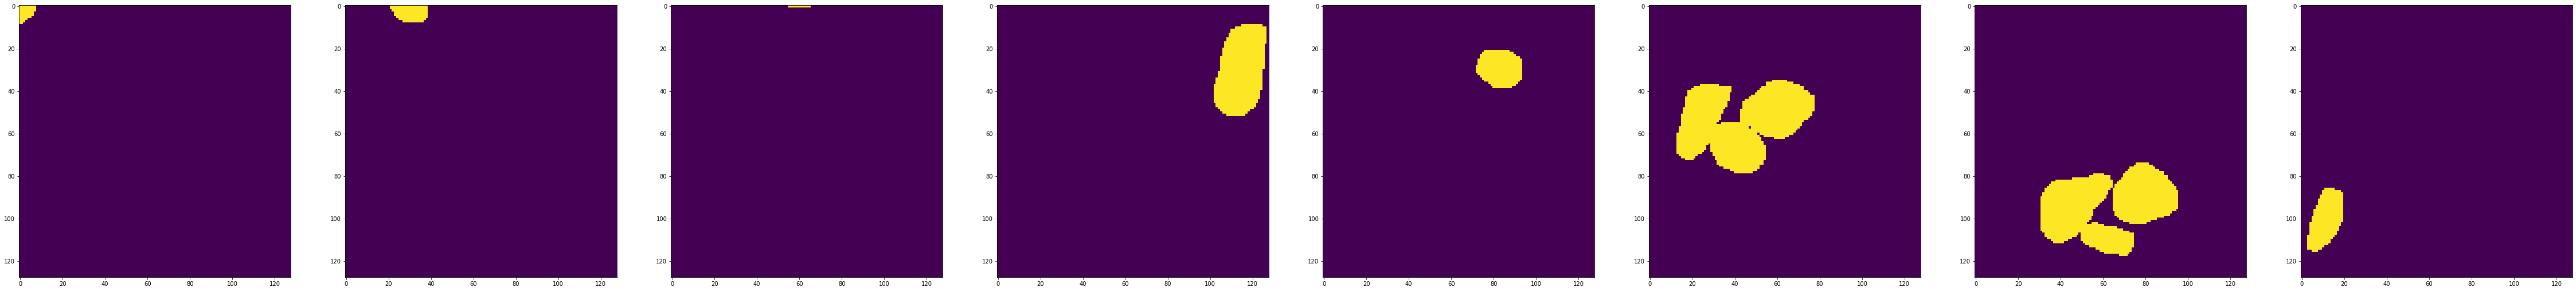

In [79]:
fig=plt.figure(figsize=(10*no_cells, 10))

for i in range(1, no_cells):
    cell = cells == i
    fig.add_subplot(1, no_cells, i)
    plt.imshow(cell)

### Generated mask cells

Number of cells in the generated mask: 10


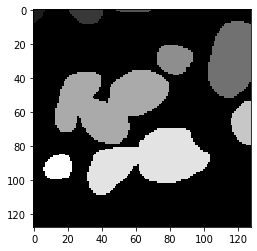

In [80]:
no_detected_cells, detected_cells = cv2.connectedComponents(mask)
plt.imshow(detected_cells * 20, cmap='gray')
print("Number of cells in the generated mask: " + str(no_detected_cells))

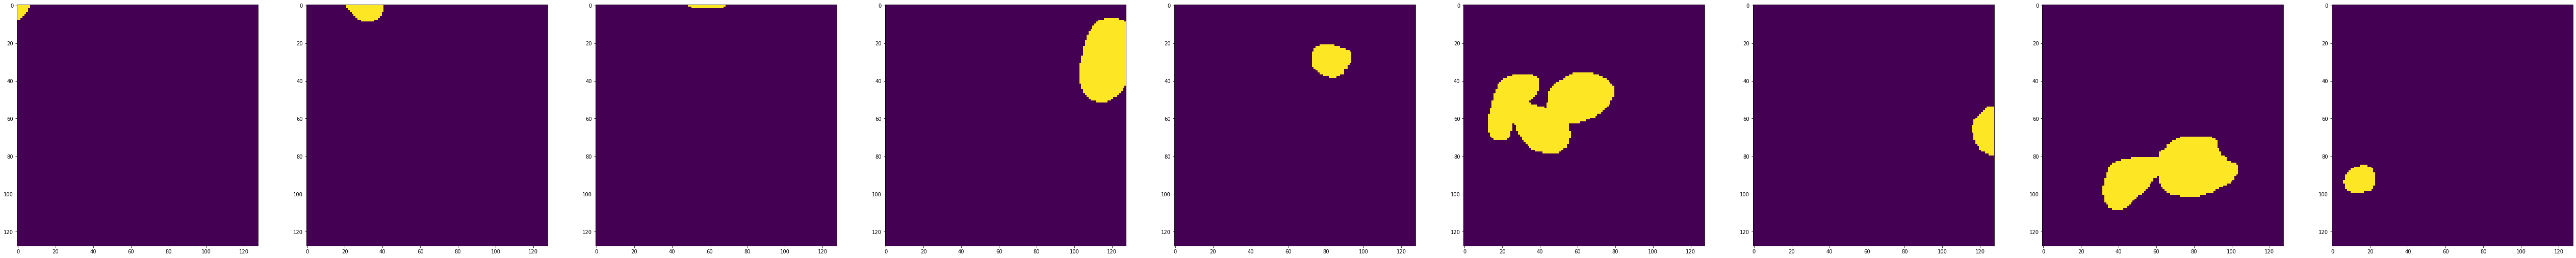

In [81]:
fig=plt.figure(figsize=(10*no_detected_cells, 10))

for i in range(1, no_detected_cells):
    cell = detected_cells == i
    fig.add_subplot(1, no_detected_cells, i)
    plt.imshow(cell)

### Calculation of TP and FN (detected at least by 50% of area)

In [92]:
t = 0.5

tp = 0
fn = 0
fp_sub = 0

for i in range(1, no_cells):
    # get cell
    cell = cells == i
    
    # find if at least t*100% of the cell was detected    
    if (cell * _intersection).sum() >= (cell.sum()*t):
        tp += 1
    else:
        fn += 1
    
    # update mask and intersection (so that one cell is not counted multiple times)
    detected_cell_indices = np.unique(cell*detected_cells)
    _mask[np.isin(detected_cells, detected_cell_indices)] = 0
    _intersection = _ground_truth * _mask

    # find the extra cells in case of the cell sub-division
    detected_cell_indices = detected_cell_indices[detected_cell_indices != 0]
    if len(detected_cell_indices) > 1: fp_sub += (len(detected_cell_indices) -1)
    
    
print('TP: ' + str(tp))
print('FN: ' + str(fn))
print('FP_sub: ' + str(fp_sub))

TP: 7
FN: 1
FP_sub: 0


### Calculation of FP and TN 


FP - detected cells which were not present in the ground truth

TN - 1 if at least 50% of background was detected

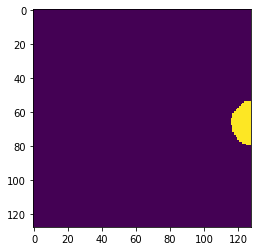

In [83]:
remaining_cells = detected_cells * _mask
plt.imshow(remaining_cells)

In [84]:
fp = len(np.unique(remaining_cells)) - 1
fp

1

In [85]:
if (detected_cells==0).sum() >= (cells==0).sum()*t:
    tn = 1
else:
    tn = 0
    fn +=1
tn

1

### Visualizing the overlap, TP, FP and FN cells

Text(0.5, 1.0, 'Overlap')

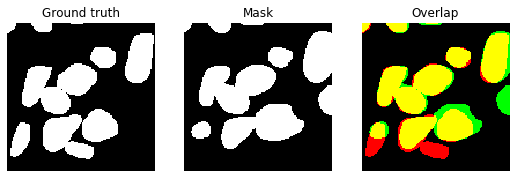

In [136]:
mix = np.zeros((128,128,3), dtype='uint8')
mix[:,:,0] = ground_truth
mix[:,:,1] = mask

fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,3,1)
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')
ax.set_title('Ground truth') 

ax = fig.add_subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.axis('off')
ax.set_title('Mask') 

ax = fig.add_subplot(1,3,3)
plt.imshow(mix)
plt.axis('off')
ax.set_title('Overlap') 


### Accuracy

In [86]:
k=1
(tp + tn) / (tp + tn + fn + fp + k*fp_sub)

0.8

### Actual function use

In [138]:
import metrics 

metrics.cell_count_accuracy(ground_truth, mask)

0.8

In [139]:
metrics.cell_count_accuracy(ground_truth, mask, return_raw=True)

(7, 1, 1, 1, 0)

In [3]:
import numpy as np
np.array([1,2,3]) - [0]

array([1, 2, 3])

### Abstract example with sub-segmenting regions

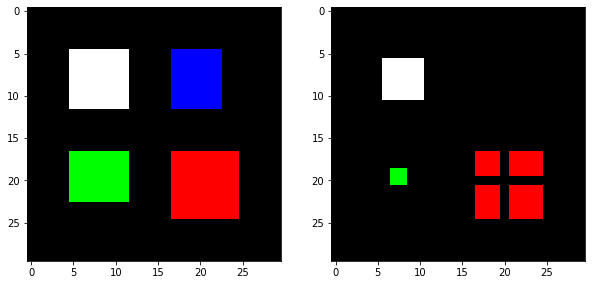

In [112]:
gt = np.zeros((30,30,3))
gt[5:12, 5:12, :] = 1
gt[6:11, 6:11, :] = 1
gt[17:25, 17:25, 0] = 1
gt[17:23, 5:12, 1] = 1
gt[5:12, 17:23, 2] = 1

segmentation = np.zeros((30,30,3))
segmentation[6:11, 6:11,:] = 1

segmentation[17:20, 17:20, 0] = 1
segmentation[17:20, 21:25, 0] = 1
segmentation[21:25, 21:25, 0] = 1
segmentation[21:25, 17:20, 0] = 1

segmentation[19:21, 7:9, 1] = 1

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.imshow(gt)
fig.add_subplot(1,2,2)
plt.imshow(segmentation)

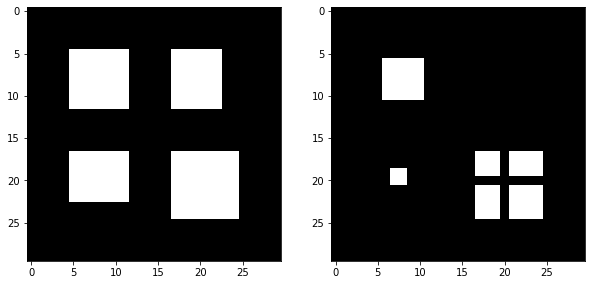

In [129]:
gt_bw = np.zeros((30,30))
gt_bw[5:12, 5:12] = 1
gt_bw[6:11, 6:11] = 1
gt_bw[17:25, 17:25] = 1
gt_bw[17:23, 5:12] = 1
gt_bw[5:12, 17:23] = 1

s = np.zeros((30,30))
s[6:11, 6:11] = 1
s[17:20, 17:20] = 1
s[17:20, 21:25] = 1
s[21:25, 21:25] = 1
s[21:25, 17:20] = 1
s[19:21, 7:9] = 1

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.imshow(gt_bw, cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(s, cmap='gray')